# Data Acquisition <a name="data_aquisition"></a>

The objective is to get the train and test data sets and extract basic information before starting the data exploratory phase.

## Data Source <a name="data_source"></a>

The data come from Kaggle and has been downloaded [here](https://www.kaggle.com/c/demand-forecasting-kernels-only/data).


## Dataset Basic Information <a name="dataset_basic_information"></a>

We need to know how much data do we have in our data sets to help us determining a list of algorithms that will suit better to achieve the objectives.

- Number of rows
- Number of columns
- Percentage: number of rows of a data set / total number of rows of test + train sets * 100


In [10]:
# Libraries used in this document.
import math
import pandas
import numpy as np
import matplotlib.pyplot as plt
import datetime
import itertools
import statsmodels as sm
import scipy.stats as stats

from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import adfuller, kpss, acf
from random import randint

import sys
import warnings
from Item import *
import Utils
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [11]:
train = pandas.read_csv("./data/train.csv", parse_dates=['date'], index_col=['date'])
train_number_of_rows = len(train.index)
train_number_of_cols = len(train.columns) + 1
print("Train set - Number of rows:", train_number_of_rows)
print("Train set - Number of columns:", train_number_of_cols, "\n")
print(train.head())
print(train.tail())


test = pandas.read_csv("./data/test.csv", parse_dates=['date'], index_col=['date'])
test_number_of_rows = len(test.index)
test_number_of_cols = len(test.columns) + 1
print("\nTest set - Number of rows:", test_number_of_rows)
print("Test set - Number of columns:", test_number_of_cols)

percentage_test = round(test_number_of_rows / (test_number_of_rows + train_number_of_rows) * 100, 2)
print("The test set contains", percentage_test, "% of the overall datasets.\n")

number_of_stores = len(set(train.store))
number_of_items = len(set(train.item))
print("Number of stores:", number_of_stores)
print("Number of items per store:", number_of_items)

## Preparation
store_id = randint(1, 10)
item_id = randint(1, 50)
item = Item(store_id, item_id)
item.selectFrom(train)

Train set - Number of rows: 913000
Train set - Number of columns: 4 

            store  item  sales
date                          
2013-01-01      1     1     13
2013-01-02      1     1     11
2013-01-03      1     1     14
2013-01-04      1     1     13
2013-01-05      1     1     10
            store  item  sales
date                          
2017-12-27     10    50     63
2017-12-28     10    50     59
2017-12-29     10    50     74
2017-12-30     10    50     62
2017-12-31     10    50     82

Test set - Number of rows: 45000
Test set - Number of columns: 4
The test set contains 4.7 % of the overall datasets.

Number of stores: 10
Number of items per store: 50


The sales frequency is daily implying that there are $5 \times 365 + 1 = 1826$ days per item where the year 2016 has 366 days.

## Applicable Algorithms <a name="applicable_algorithm"></a>
We know that we have the sales for the 5 past years (2013-01-01 to 2017-12-31) from which we have to forecast the sales for the next 3 months (2018-01-01 to 2018-03-31). 

As the objectives specified, the following algorithms will be used in order to predict the next 3 months of sales:
- Seasonal and non-seasonal ARIMA (including or not exogenous variables)
- Neural Networks
- XGBoost (Extreme Gradient Boosting Trees)

# Data Exploration <a name="data_exploration"></a>

The objective is to explore the training set in order to understand and visualize how the sales varies in function of the time for a random item of a random store. We take a random item because we only want to have an idea of how behave the sales and every time we will run this notebook, a new random item will be explored.

We have to check in the time series given in the train set:
- the seasonal behavior of the sales of the item in the store
- the seasonality and non seasonality trend of the sales over time
- the stationarity of the time series

Since this is items in stores demand, we know that it is about shopping. We are then interested on:
- __Sales by weekday__ because people may buy more on weekends (Friday, Saturday and Sunday), since most of people do not work on weekends.
- __Sales before, during and after holidays__ For example, people are generally in a rush to buy gifts just before Christmas (like December 23rd, December 24th). However, stores are mostly closed on Christmas.
- __Months or seasons (Winter, Spring, Summer and Fall)__ For example, if the store sells items used to sports practiced on Spring and Summer, people will start to buy on January or February until June or July in order to be ready for the Spring or/and Summer. Once the Summer will be at its end (August or September), it will be too late and then, the sales should decrease.
- __Anomalies__ because if the store got dammage or was robbed, the sales will be very low or even $0$. If there is a special event near the store, people may buy more items at that moment where normally the sales are not that good at that period of the year. That could also be human mistake that has impacts on the calculations of the sales.

In [12]:
train.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [13]:
train.shape

(913000, 3)

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB


Sales range from 0 to 231.


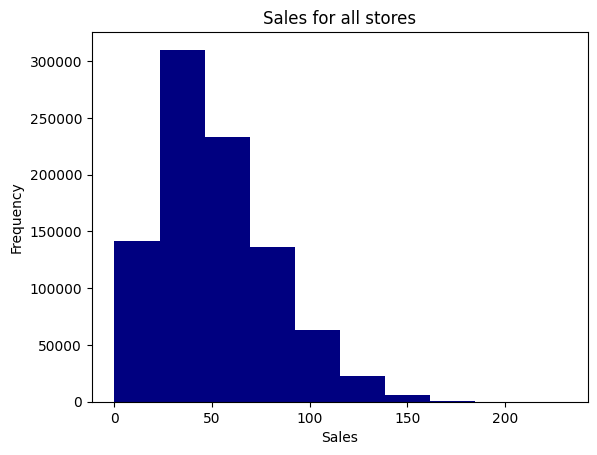

In [15]:
print("Sales range from {} to {}.".format(train['sales'].min(), train['sales'].max()))
plt.hist(train['sales'], color='navy')
plt.title("Sales for all stores")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.show()

## Empty, NA, NaN Values <a name="empty_values"></a>
Before analyzing the dataset, let's check for empty, NA or NaN values.

In [16]:
print(train.isnull().values.any())

False


## Stores Sales Mean By Year
One of the questions we have to answer from the main objectives is to know if we can apply the same model on all stores or should we apply a different model per store. One way to answer this is to visualize the sales pattern of the 10 stores.

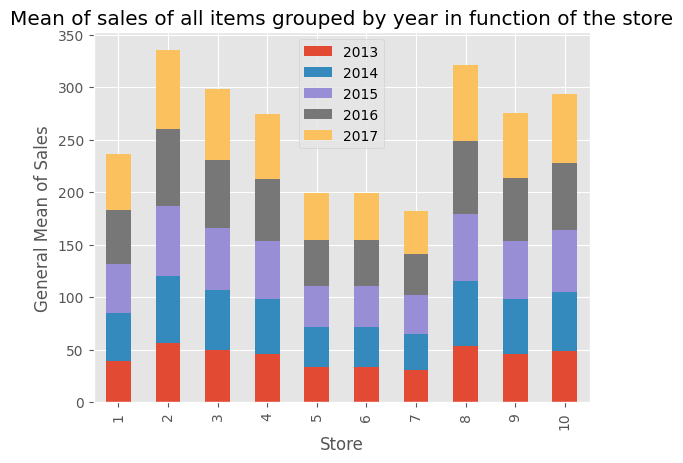

In [17]:
train_copy = train.copy()
store_year_mean = train_copy.groupby('store')['sales'].resample('YS').mean().reset_index()

store_year_mean = store_year_mean.set_index(['date', 'store']).stack().unstack('date').fillna(0)
train['year'] = train.index.year

dates = set(store_year_mean.stack().index.get_level_values(2))
dates = sorted([date.year for date in dates])

plt.style.use('ggplot')
ax = store_year_mean.plot(kind='bar', 
                          stacked=True, 
                          title='Mean of sales of all items grouped by year in function of the store')
ax.set(xlabel='Store', ylabel='General Mean of Sales')
ax.set_xticklabels(store_year_mean.index.get_level_values('store'))
ax.legend(dates);

The store 7 has the lowest sales value whereas the stores 2 and 8 have the highest ones. We see that the sales increases year after year. Adding the year as a feature should help for isolation of outliers and for the extreme gradient boosting trees model. It may also be useful as an exogenous variable to help the (S)ARIMA model.

Let's see if there is a pattern on the total daily sales for every store.

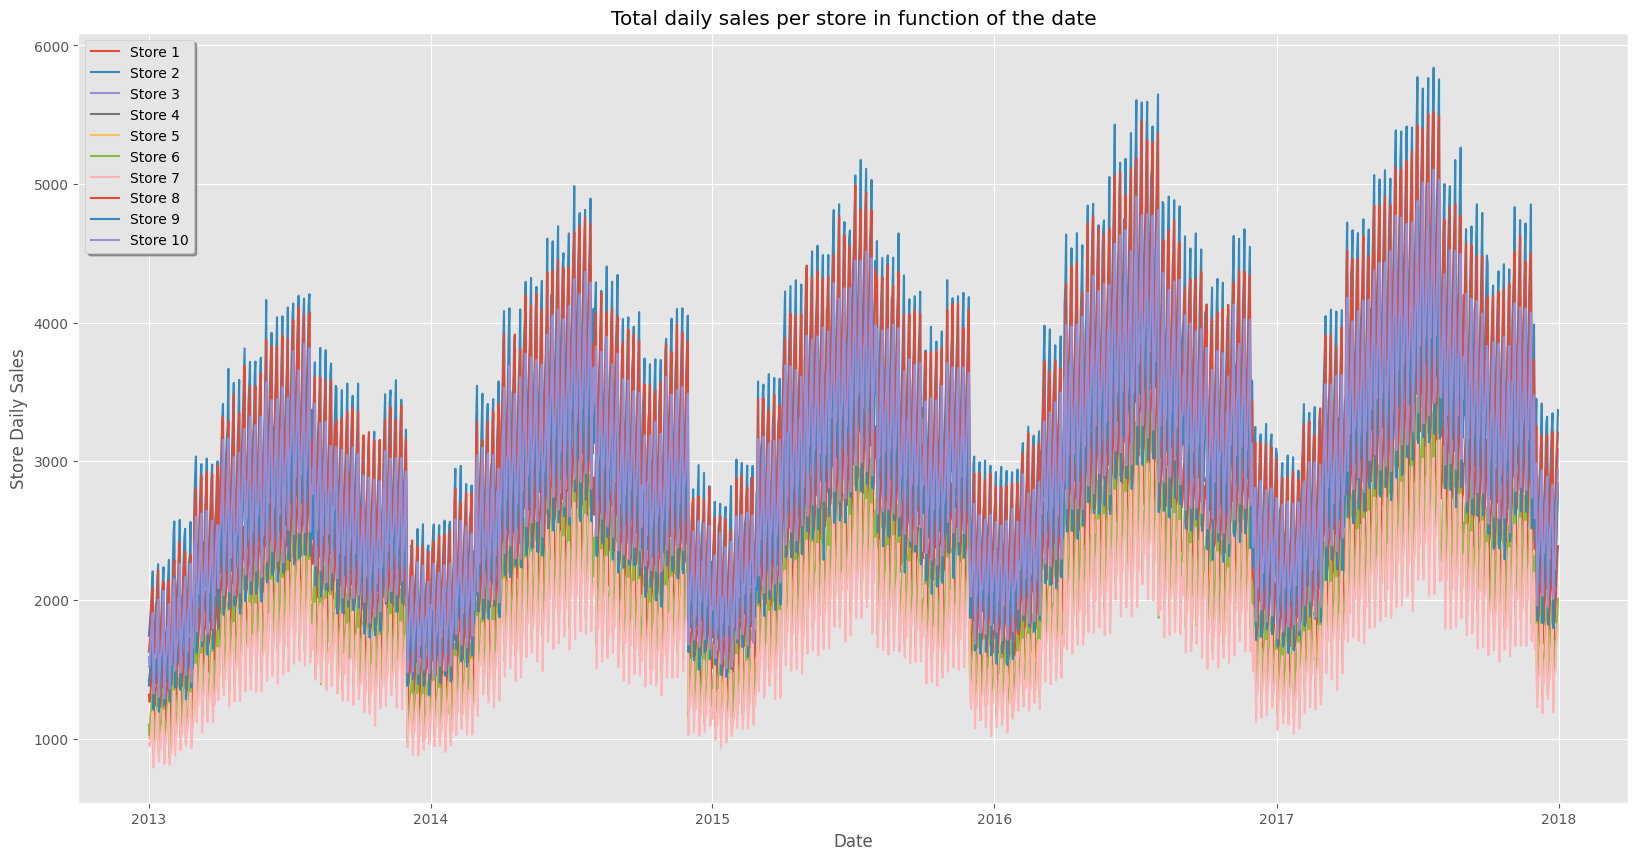

In [18]:
store_color_map = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

plt.figure(figsize=(20, 10))
plt.title("Total daily sales per store in function of the date")

for store_id in range(number_of_stores):
    global_sales_of_store = pandas.pivot_table(train[train.store == store_id + 1], 
                                               index=['date'],
                                               columns=['store', ],
                                               values='sales',
                                               aggfunc=np.sum)
    plt.plot(global_sales_of_store, 
             color=store_color_map[store_id],
             label="Store " + str(store_id + 1))

plt.legend(loc='upper left', shadow=True)
plt.xlabel('Date')
plt.ylabel('Store Daily Sales')
plt.show()

All stores follow the same sales pattern. We may think of store chains selling the same 50 items located in different areas where some of the stores attract more or less people based on the area they are located and their needs. A first hypothesis would be that there are more people at the location of the stores 2 and 8 implying that the probability that more people buy there is higher.

A second hypothesis would be that the needs are bigger for stores 2 and 8 than the other stores assuming a similar number of people located around each of the stores. For the store 7, only a small percentage of the population needs to buy there.

## Random Item Visualization <a name="random_item"></a>
In a time series, the mean and standard deviation change in function of the time. In that case, we have to use the rolling mean and standard deviation in order to detect trends per month and also to overview the difference between the seasons for each year.

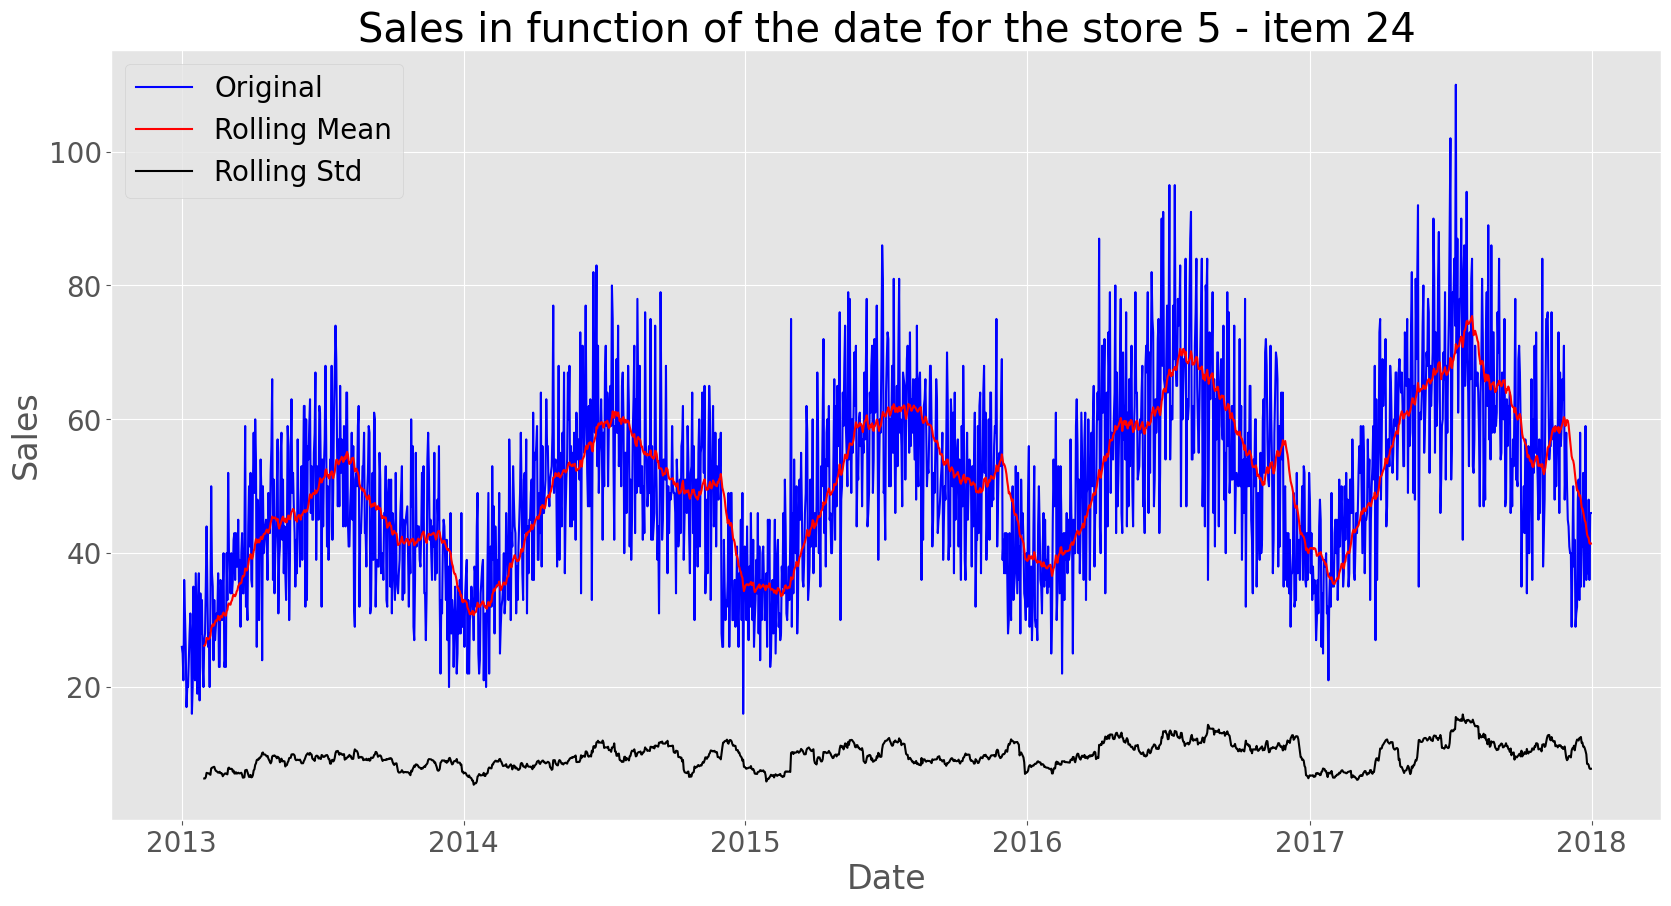

In [19]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from Item import *


# Determine the rolling means and the standard deviation per month of the item object.
def PlotRollingMeanAndStd(item):
    rollmean = item.dataset.sales.rolling(30).mean()
    rollstd = item.dataset.sales.rolling(30).std()

    # Plot the item sales, the rolling mean and the rolling standard deviation.
    plt.figure(figsize=(20, 10))
    plt.rcParams.update({'font.size': 20})
    plt.plot(item.dataset['sales'], color='blue',label='Original')
    plt.plot(rollmean, color='red', label='Rolling Mean')
    plt.plot(rollstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title("Sales in function of the date for the store " + str(item.store_id) + " - item " + str(item.item_id))
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()
PlotRollingMeanAndStd(item)

We clearly see a pattern of increasing and decreasing trends described by the mean every year. The variance is not varying significantly. Thus, there is no need to apply a logarithm or square root transformation on the sales in order to stabilize the variance. Let's take a look at the seasonal decomposition plot.

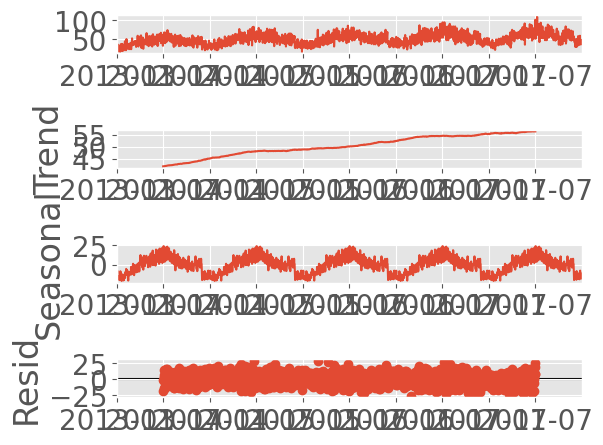

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose
def PlotSeasonalDecomposition(dataset, frequency):
    diagnostics = seasonal_decompose(dataset, model='additive', period=frequency)
    diagnostics.plot()
    #plt.subplots_adjust(left=None, bottom=None, right=2, top=1.5, wspace=None, hspace=0.1)
    plt.show()
PlotSeasonalDecomposition(item.dataset, frequency=365)

From the trend plot, we see that the sales trend increase slowly over years which shows the non stationarity of the time series. We also see the pattern on the seasonal plot where this pattern is repeated every year. 


## Store Sales Mean By Weekdays <a name="weekdays_sales_visualization"></a>
We want to visualize what is the trend of the week days and which one has the best and worst sales of the week.

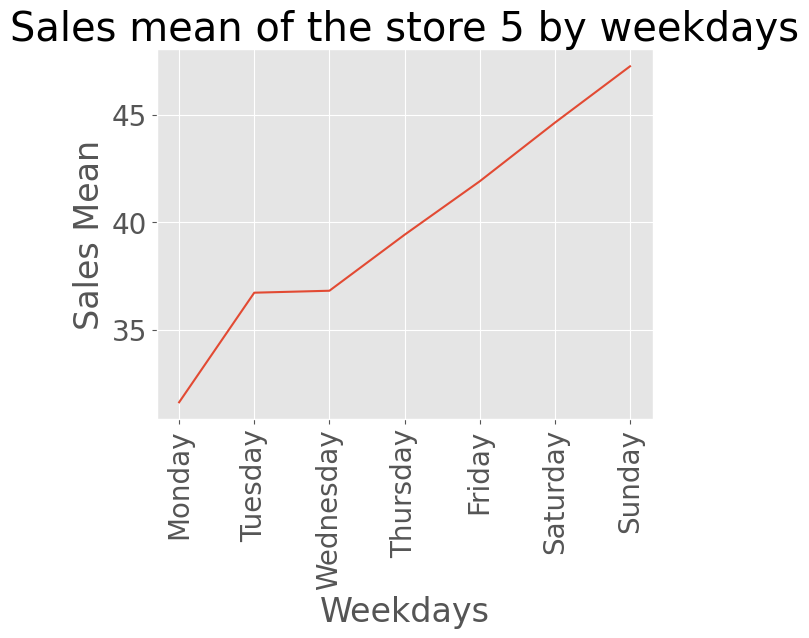

In [21]:
import calendar

store = train.loc[train.store == item.store_id, ['sales']]
train['weekday'] = train.index.weekday

store_mean_by_day = store.groupby(store.index.weekday).mean()
ax = store_mean_by_day.plot(legend=None, title="Sales mean of the store " + str(item.store_id) + " by weekdays")
ax.set(xlabel='Weekdays', ylabel='Sales Mean')
ax.xaxis.set_ticks(np.arange(len(list(calendar.day_name))))
ax.xaxis.set_ticklabels(list(calendar.day_name), rotation=90);

We see that the sales increase in general from Monday to Sunday. However, Saturday and Sunday are the week days with the best sales. This follows the fact that people are shopping on weekends because they are mostly working on business days. Furthermore, stores may be opened later on Friday which could explain why the sales increased considerably from Friday to Sunday.

We added the weekday feature where the weekdays are identified as Monday ($0$), Tuesday ($1$) until Sunday ($6$).


## Stores Sales Mean By Month <a name="stores_sales_mean_by_month"></a>
The objective is to visualize the sales mean by month in order to observe if there is a clear pattern and then deduce the stationarity of the time series.

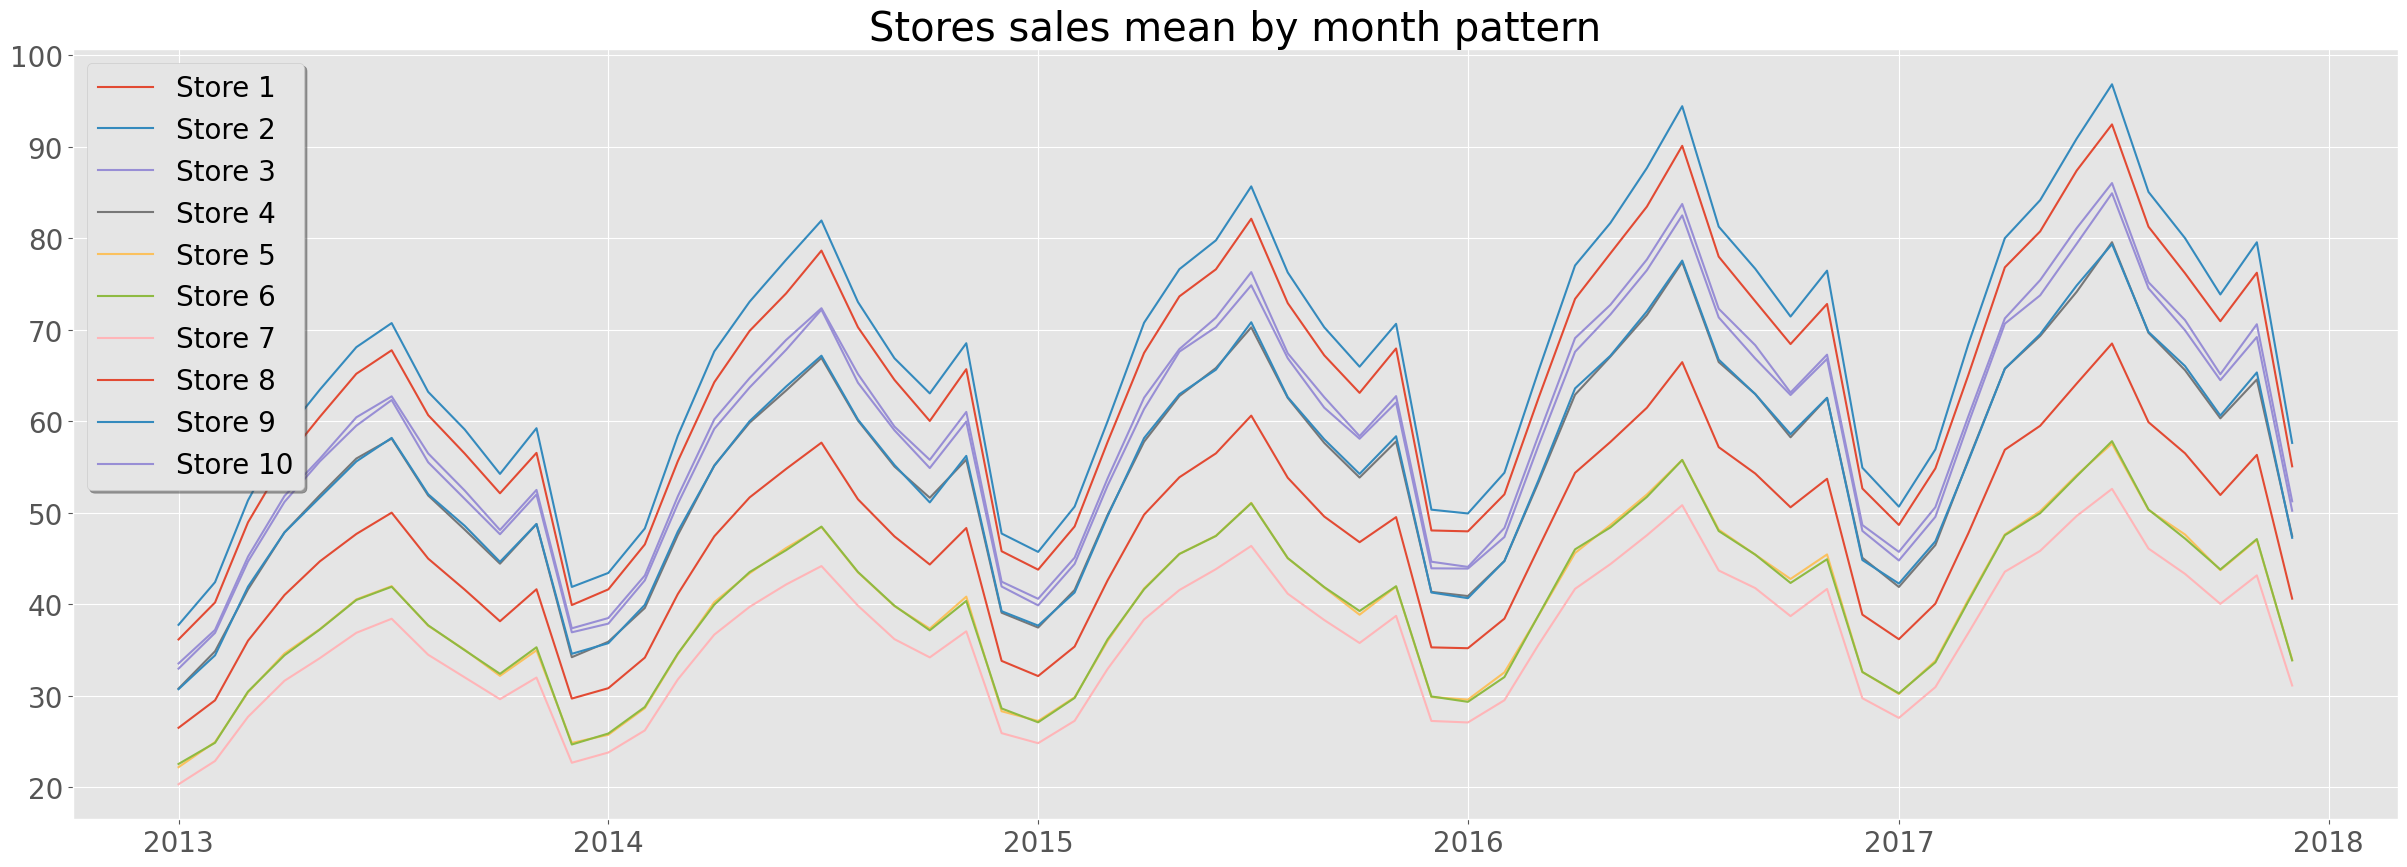

In [22]:
train['month_number'] = train.index.month

store_color_map = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
plt.figure(figsize=(30, 10))
plt.title("Stores sales mean by month pattern")

for i in range(number_of_stores):
    store = train.loc[train.store == i+1, ['sales']]
    
    store_by_month_mean = store['sales'].resample("MS").mean()
    plt.plot(store_by_month_mean, 
             color=store_color_map[i],
             label="Store " + str(i+1))
plt.legend(loc='upper left', shadow=True);

The following observations are identified:
- The trend increases slowly from year to year.
- The trend is clearly varying from month to month. 
- The trend seems to follow a similar pattern year after year. 

The time series has a seasonality pattern. In general, we have the following observations:
- From January to June, the sales are increasing. 
- It may occur that from March to April, the sales decreases a little.
- From June to September, the sales are decreasing.
- From September to October, the sales are increasing.
- From October to December, the sales are decreasing.
- From December to January, the sales are increasing. (It may occur that the sales continue to decrease.)

According to this plot, we assume that one model should fit for all stores in this dataset because their pattern is similar between them.

In order to know if the month of the year is important, we want to visualize what are the sales mean of all stores for every month of the 5 years. 

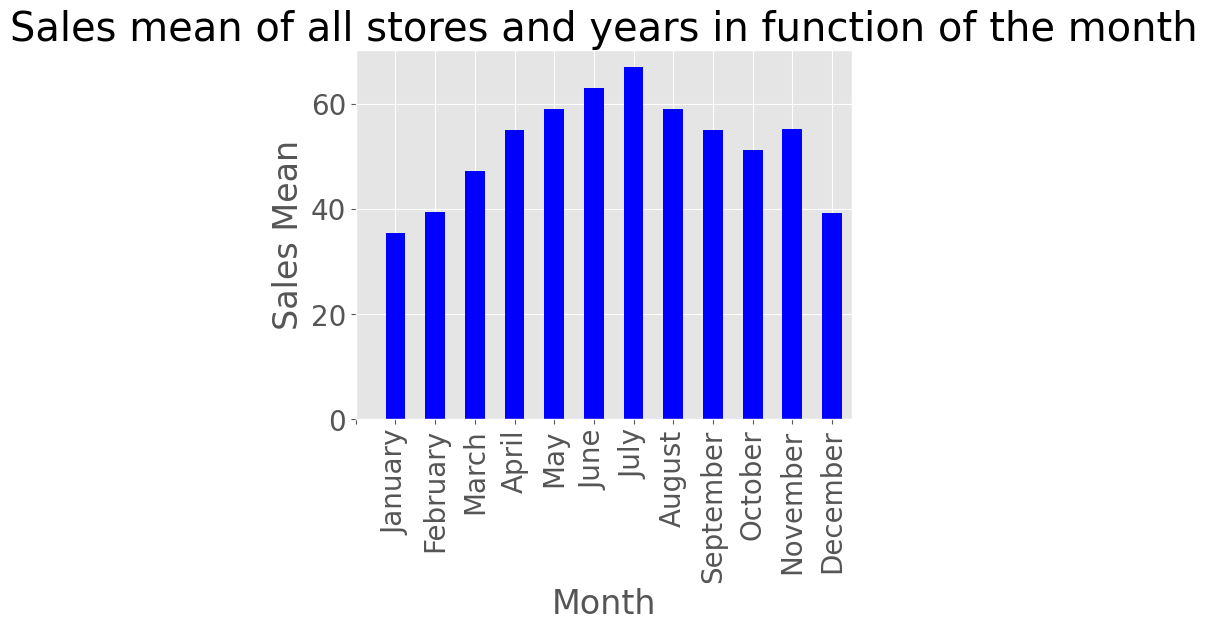

<Figure size 1500x1000 with 0 Axes>

In [23]:
ax = train[['sales', 'month_number']].groupby(["month_number"]).mean().plot.bar(color='blue', legend=None)
plt.title("Sales mean of all stores and years in function of the month")
plt.xlabel('Month')
plt.ylabel('Sales Mean')
plt.figure(figsize=(15, 10))
ax.xaxis.set_ticks(np.arange(-1, len(list(calendar.month_name))-1))
ax.xaxis.set_ticklabels(list(calendar.month_name), rotation=90);
plt.show()

There is a considerable increasing of sales starting on Spring season (on March) and we observe that May, June, July and August have the highest sales of the year. We assume that those stores are selling items related to the Summer season. However, note that there is a suddent increase of sales on November.

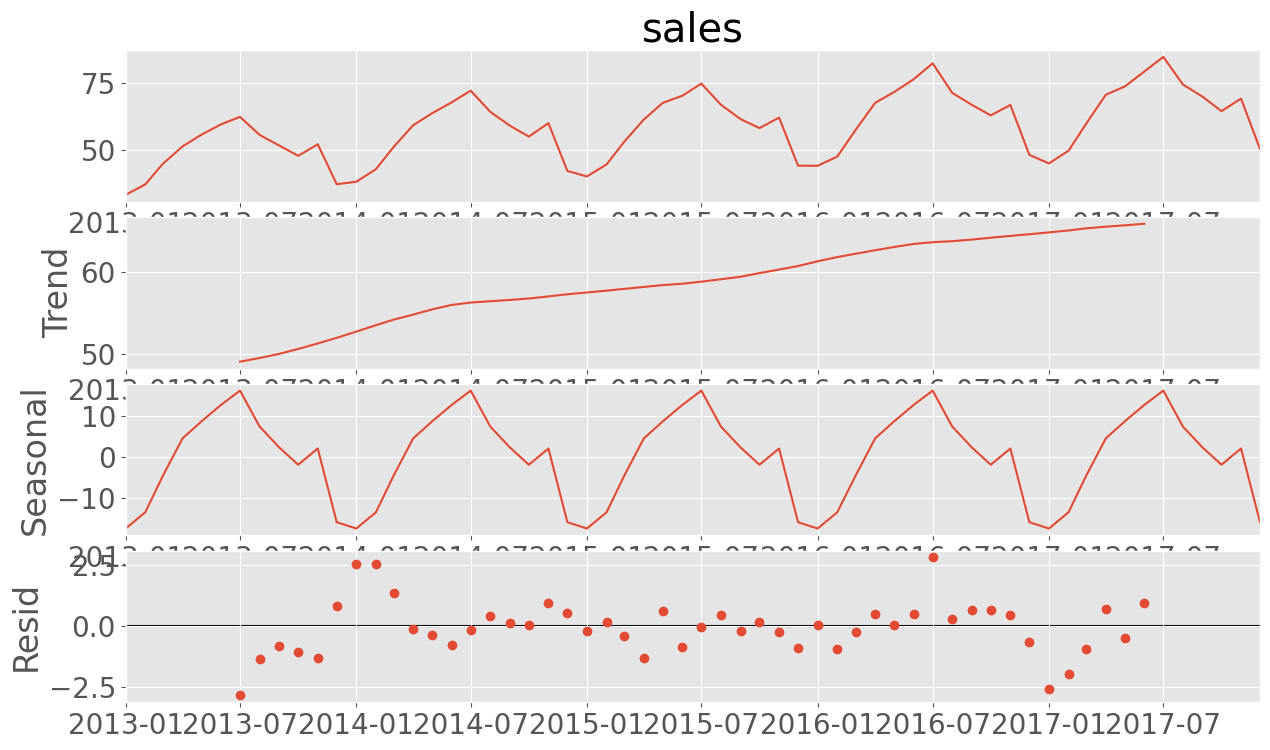

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose
def PlotSeasonalDecomposition(dataset, frequency):
    diagnostics = seasonal_decompose(dataset, model='additive', period=frequency)
    diagnostics.plot()
    plt.subplots_adjust(left=None, bottom=None, right=2, top=1.5, wspace=None, hspace=0.1)
    plt.show()
PlotSeasonalDecomposition(store_by_month_mean, frequency=None)

The trend is not constant implying that the time series is not stationary. We see that the pattern is clear for the seasonal time series which is repeated every year.

## Holidays <a name="holidays"></a>
The objective is to identify the holidays for every year for the following reasons:
- The stores may be closed on holidays implying that the sales drop specifically on these days.
- Few days before the holidays, the sales may have a boost (e.g. Christmas).
- Few days after the holidays, the sales may have a boost because there are significant discounts on items. This should attract more people to buy (e.g. Boxing days).

We assume that the stores are located in the US. We downloaded the file `usholidays.csv` on [Kaggle](https://www.kaggle.com/gsnehaa21/federal-holidays-usa-19662020) in order to get the necessary holidays in the US that include years 2013 to 2018 inclusively.

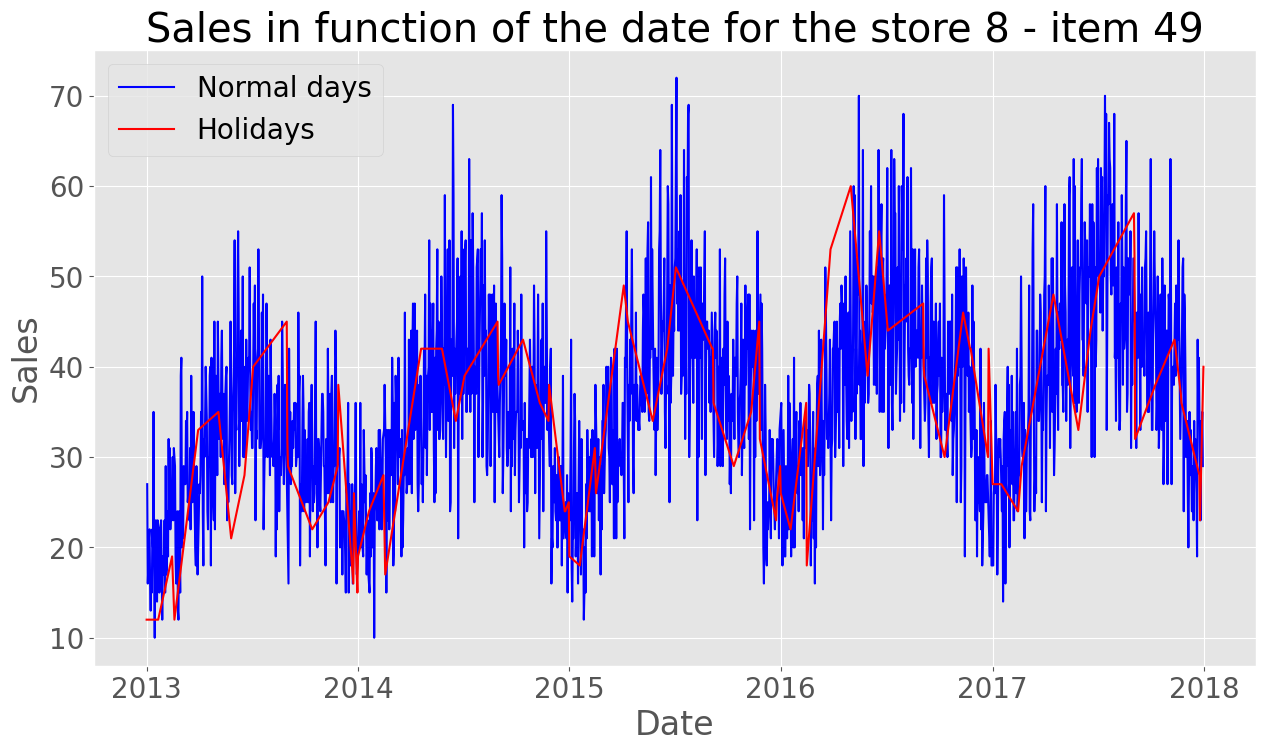

In [17]:
holidays = pandas.read_csv('./Data/USHolidayDates.csv', 
                           usecols=["Date", "Holiday"], 
                           parse_dates=['Date'])

holidays.columns = ['date', 'is_holiday']

# Merging with the train set.
train.reset_index(inplace=True)
train.columns.str.replace('index', 'date')
train = pandas.merge(left=train, 
                     right=holidays, 
                     how='left',
                     on='date',
                     sort=False).set_index('date')
train.is_holiday = pandas.notnull(train.is_holiday).astype(int)

# Merging with the test set.
test.reset_index(inplace=True)
test.columns.str.replace('index', 'date')
test = pandas.merge(left=test, 
                    right=holidays, 
                    how='left',
                    on='date',
                    sort=False).set_index('date')
test.is_holiday = pandas.notnull(test.is_holiday).astype(int)

item_holidays = train.loc[(train.store == item.store_id) & (train.item == item.item_id) & (train.is_holiday == 1), ['sales']]
item_not_holidays = train.loc[(train.store == item.store_id) & (train.item == item.item_id) & (train.is_holiday == 0), ['sales']]

plt.figure(figsize=(15, 8))
plt.plot(item_not_holidays, color='blue', label='Normal days')
plt.plot(item_holidays, color='red', label='Holidays')
plt.title("Sales in function of the date for the store " + str(item.store_id) + " - item " + str(item.item_id))
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(loc='best')
plt.show()

According to the plot, the sales on holidays seem to be low compared to the non holidays sales which strengthen our hypothesis on low sales on holidays.

## Anomalies Detection <a name="anomalies_detection"></a>
The objective is to detect sales that are increasing or decreasing significantly in few days compared to the others. This should help to identify particular dates and then verify if there these were special events on these dates. Identifying the outliers in this context will be used (as exogenous variables or new features) to help the models getting more accurate when predicting future sales. For example, if a special event occurs every year where the sales increase significantly, we should see these outliers every year at the same date.

Furthermore, we do not have enough information on the stores and items to confirm that incorrect sales have been entered by mistake or something like that. Therefore, the objective is not to remove those outliers but to get insights to help the models.

Let's see the scatter plot of an item taken randomly in order to visualize data points that may be consider as outliers.

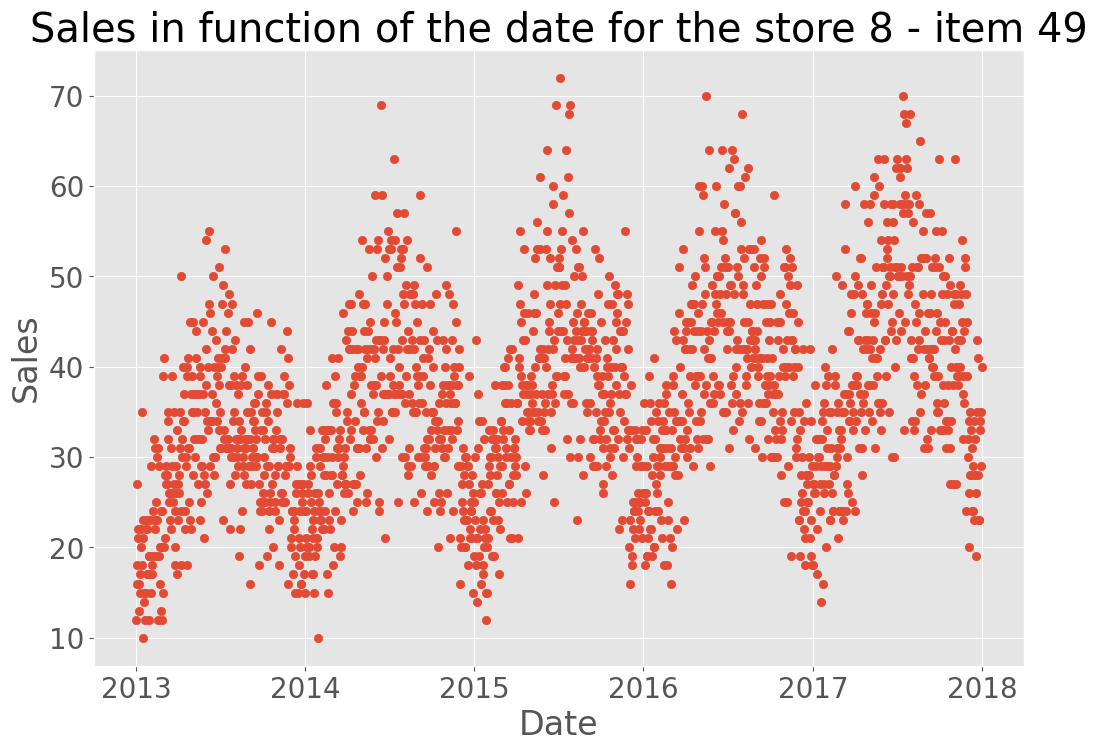

In [18]:
plt.figure(figsize=(12, 8))
plt.scatter(x=item.dataset.index, y=item.dataset.sales)
plt.title("Sales in function of the date for the store " + str(item.store_id) + " - item " + str(item.item_id))
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

According to this scatter plot, the following actions could be used to detect outliers:
- If the sales considered as anomalies occur during holidays or special events, we could use a method to isolate them. 
- It could make sense that if a special event occurs, the sales increase significantly compared to the days before. In such case, comparing the data point against the distance from the rolling mean has to be considered.

### Outliers Isolation <a name="outliers_isolation"></a>
Another way to detect outliers is to use the isolation forest algorithm. The objective of this algorithm is to isolate data points based on the assumption that outliers are data points that are different from the others and rare. Therefore, only few conditions are necessary to find outliers contrarily to the normal data points. (ref. [isolation-based Anomaly Detection](https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/tkdd11.pdf))

We deduce that more useful features the dataset has, more accurate the isolation will be. If the dataset has only 3 features for example, the difference between few and many conditions should be non significant. Hence, the isolation should not be accurate at all.

Since the algorithm uses random decision trees, more the path to reach a data point is short, more the data point is an outlier. Due to the randomness of the algorithm, the process is repeated a certain number of times and the normalized average path length is taken as the score.

__Example__

Let say that the data point $A$ in the store 2, item 29 on 2015-11-15 has 142 of sales is an outlier. Indeed, its sales are significantly higher than the other sales on November. Let say now that the data point $N$ on 2015-11-14 has 100 of sales which is normal compared to the others of the same month (except $A$). The sales varies between $69$ and $142$. Here is a basic tree based on the sales in order to show the idea:

![Tree Example](Images/Example_Decision_Tree.png)

The score of the observation $A$ should be close to $1$ whereas the score of the observation $N$ should be much less than $0.5$.

The following steps are followed:
1. Find features that could add more conditions in order to get a better accuracy of the outliers found (done in the Data Visualization section).
2. Add the new features to the model (done in the Data Visualization section).
3. Determine an estimated proportion of the outliers over the data points in the sample.
4. Apply the model to the time series in order to obtain the outliers.

There are 365 days per year except for 2016 which has 366 days. If we estimate an average of one outlier per month and a half, there are $\frac{8}{365} = 2.1917808$% of outliers per item.

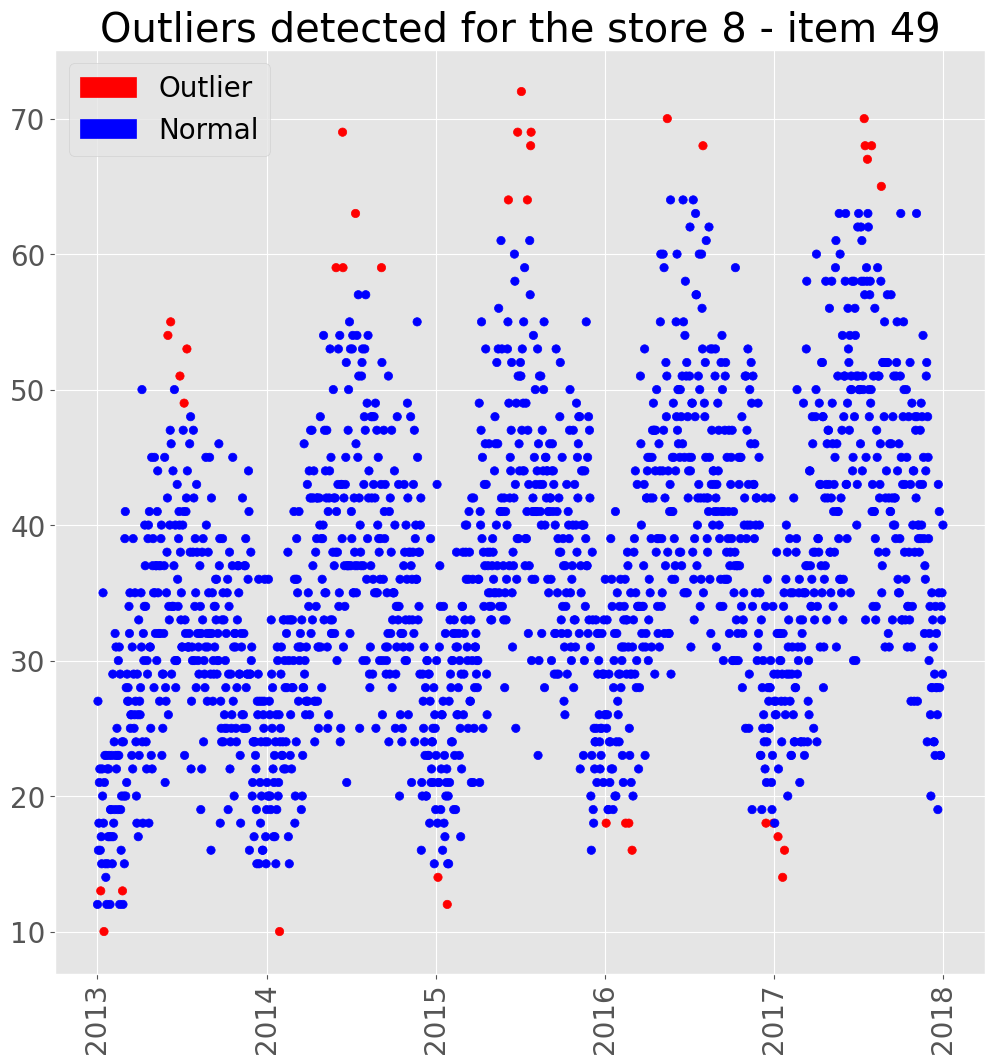

In [19]:
import Anomalies
outliers_fraction = 0.02

train['anomaly_iforest'] = Anomalies.ListAllByApplyingIsolationForest(train, outliers_fraction)
item_anomalies = train.loc[(train.store == item.store_id) & (train.item == item.item_id), ['store', 'item', 'sales', 'anomaly_iforest']]
Anomalies.scatterPlot(item_anomalies, anomaly_type='iforest')

### Z-Score Test <a name="zscore"></a>
This statistical method consists to calculate the difference between the sales mean and the actual sales and then divide the result by the standard deviation (which is the normalization of the sales assuming the sales are normally distributed). We know that the sales mean and standard deviation are varying in function of the time. Therefore, we cannot take the mean of every month. We have to take the rolling mean $\bar{X}$ and rolling standard deviation $s$ monthly for every sales $X_i$ in the month. We define the z-score as
$$Z(X_i) = \left|\frac{X_i - \bar{X}}{s}\right|.$$
In function of a positive threshold $\tau$ chosen, all $X_i$ such that $Z(X_i) > \tau$ are called outliers. 

Before using this method, we have to make sure that every sales sample $X \sim N(\mu, \sigma^2)$. In order to verify the normality of $X$, we have to apply a normality test on every sample $X$. 

More concretely, we define $X_{s,i,m}$ as a sample of a store $s \in \{1, 2, \ldots, 10\}$ containing items $i \in \{1, 2, \ldots, 50\}$ where the sales are taken for every month $m \in \{1, 2, \ldots, 12\}$ of every year $y \in \{2013, 2014, \ldots, 2017\}$ from 2013-01-01 to 2017-12-31. This gives $10 \times 50 \times 5 \times 12 = 30000$ samples of size between $28$ and $31$ which are the number of days varying in function of the month.

The objective is to test the following hypotheses:
- $H_0$ the sales in the sample $X_{s,i,m}$ come from a population normally distributed.
- $H_1$ the sales in the sample $X_{s,i,m}$ come from a population that is not normally distributed.

If $p < \alpha$, where $p$ is the p-value and $1 - \alpha$ the confidence degree, the null hypothesis $H_0$ is rejected. In such case, it is probable that the sales comes from a population not normally distributed. If $p \geq \alpha$, the null hypothesis $H_0$ is not rejected. In such case, it is probable that the sales comes from a population normally distributed.

We expect that the samples will follow a normal distribution because we assume that there are great sales and bad sales in a year. However, it may happen that the sales were great all the month meaning that the sales will not be normally distributed.

In summary, the following steps are applied:
1. Test the normality of the sales monthly for every item of every store.
2. Check if there is a high majority (90% or more) of the samples that are normally distributed.
3. Choose a confidence level ($\alpha$) and a threshold ($\tau$) where a data point starts to be considered as an outlier.
4. Apply the normalization method for each of the $30000$ samples.
5. Visualize an item as an example in order to see what outliers have been identified.

We use the Shapiro-Wilk test in order to test the normality of our $30000$ samples.

In [20]:
normality, train['anomaly_normal'] = Anomalies.ListAllByApplyingNormalization(train, number_of_std=2.4, alpha=0.05)

percentage_of_normality = (sum(1.0 for n in normality if n == 1) / len(normality)) * 100
percentage_of_not_normality = round(100 - percentage_of_normality, 2)
percentage_of_normality = str(round(percentage_of_normality, 2))
print(percentage_of_normality + "% of the samples are normally distributed.")
print(str(percentage_of_not_normality) + "% of the samples are not normally distributed.")

93.84% of the samples are normally distributed.
6.16% of the samples are not normally distributed.


According to the percentages obtained from the Shapiro-Wilk normality test, the sales by month mostly follow the normal distribution with $95$% of confidence degree.

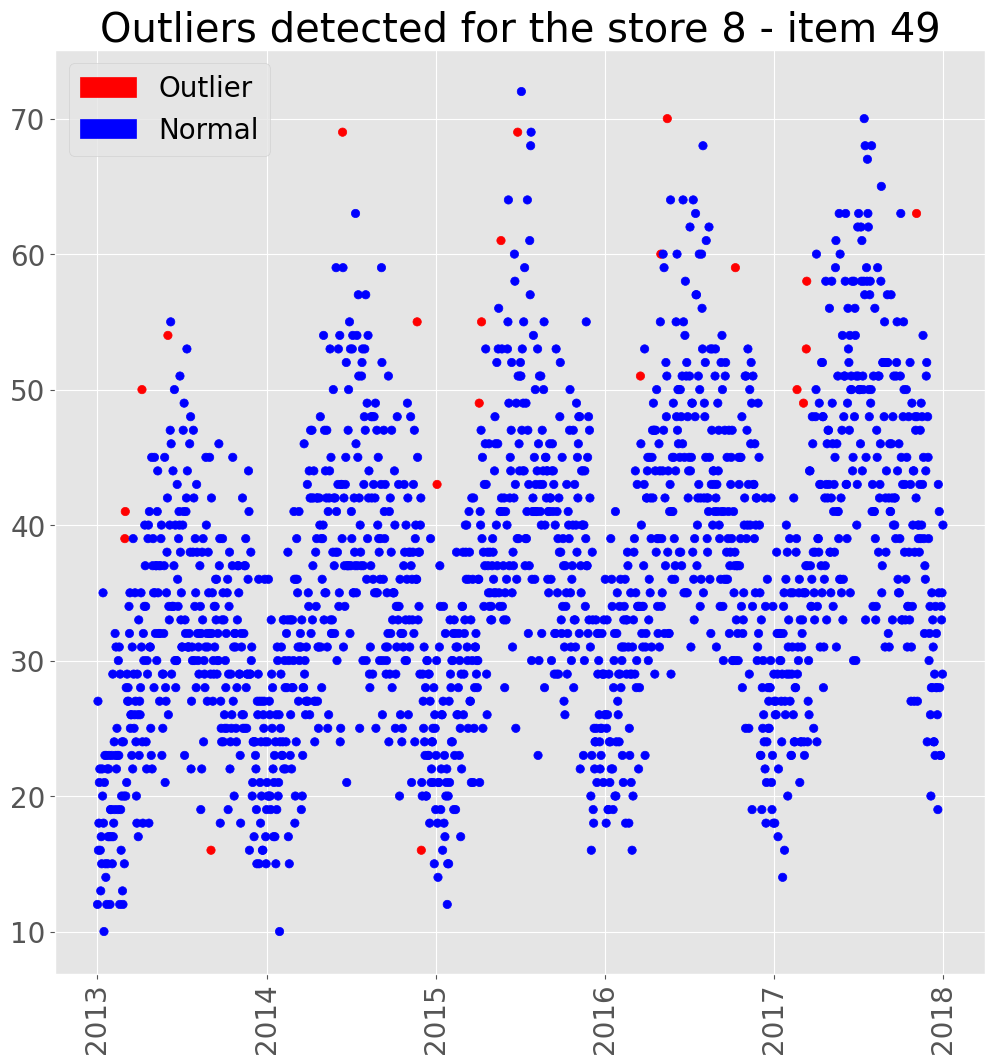

In [21]:
item_anomalies = train.loc[(train.store == item.store_id) & (train.item == item.item_id), ['store', 'item', 'sales', 'anomaly_normal']]
#item_anomalies = train.loc[(train.store == 1) & (train.item == 31) & (train.year == 2015) & (train.month_number == 7), ['sales', 'anomaly_normal']]
Anomalies.scatterPlot(item_anomalies, anomaly_type='normal')

### Inter-Quantile Range
Another way to detect outliers is to use the Inter-quantile range (IQR) method. The method consists of the following steps:
1. Calculate the first quantile (25%) of the sales noted $Q_1$.
2. Calculate the third quantile (75%) of the sales noted $Q_3$.
3. Calculate the score $S = Q_3 - Q_1$.
4. With a threshold $k$ given, calculate the normal interval $N = [Q_1 - kS, Q_3 + kS]$ where $X \not \in N$ is called an outlier.

By using this method, we assume that most of the sales are contained between the quantiles $Q_1$ and $Q_3$. 

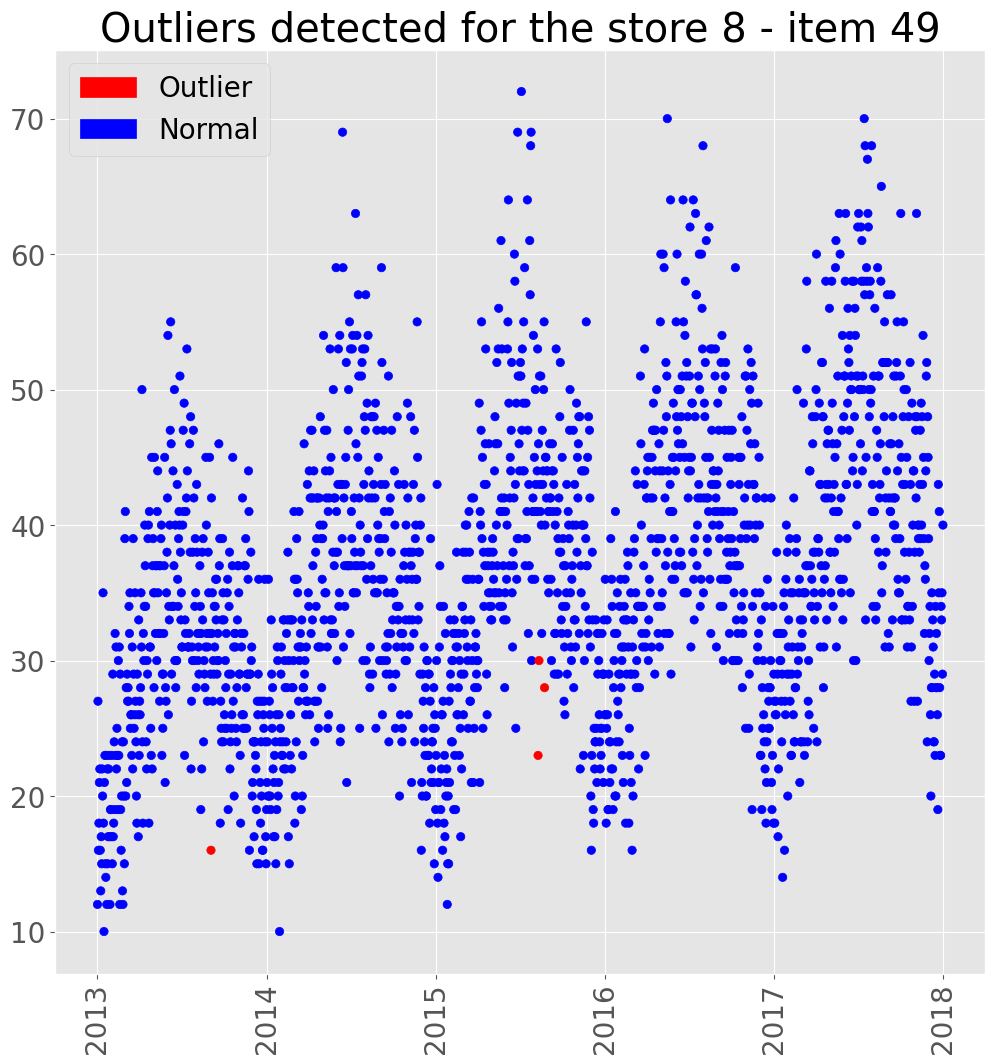

In [22]:
train['anomaly_iqr'] = Anomalies.ListAllByApplyingIQR(train, threshold=2)
item_anomalies = train.loc[(train.store == item.store_id) & (train.item == item.item_id), ['store', 'item', 'sales', 'anomaly_iqr']]

Anomalies.scatterPlot(item_anomalies, anomaly_type='iqr')